# Interupted time series analysis (ITS) modelling with restricted cubic spline and cyclical trends.

In [29]:
# Import neccesary libraries.
import pymc as pm
import pandas as pd
from utils import rcspline_eval, h, RR_hdi_calculator
from model import run_mod
import matplotlib.pyplot as plt
import numpy as np
import arviz as az

# Overview

The following is a Bayesian workflow example of an ITS analysis based on Bernal, Cummins, Gasparrini, (2017) tutorial using data from Barone-Adesi et al . (2011) and some advanced modelling options inspired by similar analysis from chapter two of Frank Harrells' wonderful [Regression Modeling Strategies](https://hbiostat.org/rmsc/) textbook. Specifically, the use of restricted cubic splines (rcs) Devlin & Weeks (1986) and cyclic trends to capture nonlinearity and seasonality due to the timeseries nature of the data whilst estimating a causal effect using an ITS analysis methodology (Bhaskaran et al. 2013).  

Causal models using ITS can be easily estimated using Python/PyMC. Prepackaged examples are available in the form provided CausalPy, one of PyMC's ever-developing extension packages (Abril-Pla et al., 2023). Currently, however, the model syntax is limited and focuses on using prediction-based methods to represent causal effects (this is likely due to the design choice of CausalPy to also support Scikit-learn forms of the models) to determine and visualise the causal effects similar to those generated by the R-based CausalImpact package (Brodersen et al. 2017). 

The design choices for ITS analysis applied within the CausalPy package are just as applicable to the following analysis (probably warranting a separate example) and the models applied. However, as stated above, the following analysis provides a Bayesian version to the tutorial analysis presented by Bernal et al., and as such, the focus here is on the statistical estimation of a causal estimand Lundberg et al. (2021), specifcally the risk ratio difference between pre and post-intervention.

## Data description

The data anlaysed below is taken from Barone-Adesi et al. (2011). Their study used an ITS design to determine the causal effect of a nation wide regulation on smoking in Italy on the standardised rate of acute coronary heart event cases (ACE) with focus in this analyis being specifically for the Sicily region.

## Import data

In [30]:
# Load in data
df = pd.read_csv("https://raw.githubusercontent.com/HPCurtis/Datasets/main/sicily.csv")

# Add datetiem for plotting.
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Identify intervention date.
intervention_time = df.time[36]
intervention_date = df.date[36]

In [31]:
df.head()

,Unnamed: 0,year,month,aces,time,smokban,pop,stdpop,rate,date
0,1,2002,1,728,1,0,364277.4,379875.3,191.641836,2002-01-01
1,2,2002,2,659,2,0,364277.4,376495.5,175.035293,2002-02-01
2,3,2002,3,791,3,0,364277.4,377040.8,209.791619,2002-03-01
3,4,2002,4,734,4,0,364277.4,377116.4,194.634866,2002-04-01
4,5,2002,5,757,5,0,364277.4,377383.4,200.591759,2002-05-01


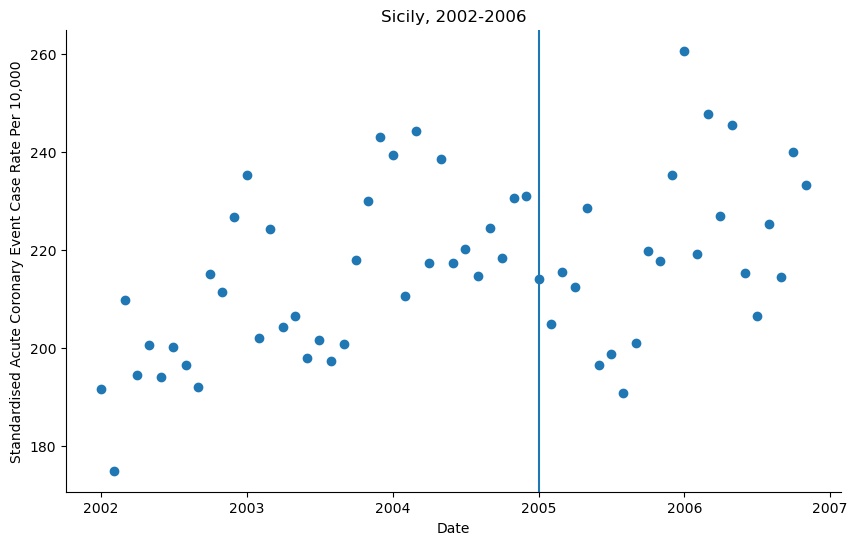

In [32]:
# Visualsie the ACE data.
_, ax = plt.subplots(figsize=(10, 6));
plt.scatter(x=df.date, y=df.rate);
plt.title("Sicily, 2002-2006")
plt.ylabel('Standardised Acute Coronary Event Case Rate Per 10,000');
plt.xlabel('Date');
plt.axvline(intervention_date);
ax.spines['top'].set_visible(False);
ax.spines['right'].set_visible(False);
plt.savefig('vis/ACE_scatter.png');

# Model overviews
For the folwing analysesnin this tutorial two sepearate models that build on top of each other were fit to the data. Both models ufndm,etnally are a form of Poisson Regression that modelled the Rate of ACE using restricted cubic splines (RCS) and offset term. The difference bertween the two models is that the second model adds cyclical terms in the form of sin and cosine functions to model 12 month seasonality. The following models are espressed in mathmatical form that coincides closely with code implementation of PyMC model found in model.py other that split of the $COS$ and $SIN$ Terms

## RCS Model

\begin{align}
y &\sim \text{Poisson}(\lambda) \\
\lambda &=  \exp\left(a + \text{offset}(z\right) + f(x) + \text{level-change} * \beta_5) \\
f(x) &= \sum_{k=1}^{4} \beta_k \phi_k(x) \\
\alpha &\sim \mathcal{N}(0, 10) \\
\beta_{1...7}  &\sim \mathcal{N}(0, 10) 
\end{align}


## RCS model with cyclic trend

\begin{align}
y &\sim \text{Poisson}(\lambda) \\
\lambda &=  \exp\left(a + \text{offset}(z\right) + f(x) + \text{COS} + \text{SIN}) + \text{level-change} * \beta_7) \\
f(x) &= \sum_{k=1}^{4} \beta_k \phi_k(x) \\
\text{COS}  &= \sin\left(\frac{2 \pi x}{12}\right) * \beta_5 \\
\text{SIN} &= \cos\left(\frac{2 \pi x}{12}\right) * \beta_6\\
\alpha &\sim \mathcal{N}(0, 10) \\
\beta_{1...7}  &\sim \mathcal{N}(0, 10) \\
\end{align}



### Generate model design matrices

No basic implementations of functions to generate design matrices for restricted cubic splines or basic cyclical trends exist in Python (or at least I couldn't find them). Therefore, I implemented the necessary functionality within the utils.py file associated with this analysis project. The implementations are based of [Frank Harrells Hmisc R package](https://github.com/harrelfe/Hmisc) 

In [33]:
# Impact component (level change here) is the column of design matrix that estimates 
# the parameter for the causal effect.
level_change = (df.time >= 37).astype(int)

# Generate design matrices for rcs model  and rcs with cyclical components
dm, knots = rcspline_eval(df.time, nk = 6)
dm_cyl = h(df.time, knots=knots)

# Add causal parameter column to each model matrix.
dm = np.column_stack((dm, level_change))
dm_cyl = np.column_stack((dm_cyl, level_change))

# Add offet to model matrix to deal with overdisperison.
offset = np.log(df['stdpop']).values

In [34]:
# Fit PyMC models stored in model.py run_mod function.
trace, model_rcs = run_mod(dm = dm, df=df, offset=offset)
trace_cyl, model_cyl = run_mod(dm = dm_cyl, df=df, offset = offset)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Output()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Output()

# Posterior checks

In [35]:
# Output MCMC summaries for model parameters rcs only model.
az.summary(trace , var_names=["alpha","beta"], hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-7.538,0.018,-7.573,-7.501,0.001,0.000,1183.0,1720.0,1.0
beta[0],0.055,0.022,0.011,0.098,0.001,0.001,738.0,1251.0,1.0
beta[1],-0.173,0.086,-0.341,-0.006,0.003,0.002,724.0,1190.0,1.0
beta[2],0.247,0.152,-0.034,0.555,0.006,0.004,709.0,1223.0,1.0
beta[3],-0.227,0.187,-0.597,0.123,0.006,0.005,847.0,1777.0,1.0
beta[4],-0.106,0.059,-0.223,0.008,0.001,0.001,2077.0,1850.0,1.0


In [36]:
# Output MCMC summaries for model parameters rcs and sine cosine function model.
az.summary(trace_cyl , var_names=["alpha","beta"], hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-7.541,0.018,-7.575,-7.505,0.000,0.000,1812.0,2111.0,1.0
beta[0],0.054,0.022,0.012,0.097,0.001,0.000,1014.0,1759.0,1.0
beta[1],-0.164,0.086,-0.333,-0.005,0.003,0.002,966.0,1729.0,1.0
beta[2],0.230,0.152,-0.043,0.538,0.005,0.003,978.0,1766.0,1.0
beta[3],-0.215,0.186,-0.579,0.148,0.005,0.004,1286.0,2182.0,1.0
beta[4],0.032,0.013,0.006,0.058,0.000,0.000,3310.0,2506.0,1.0
beta[5],0.037,0.012,0.012,0.061,0.000,0.000,3420.0,2632.0,1.0
beta[6],-0.131,0.061,-0.250,-0.011,0.001,0.001,2428.0,2683.0,1.0


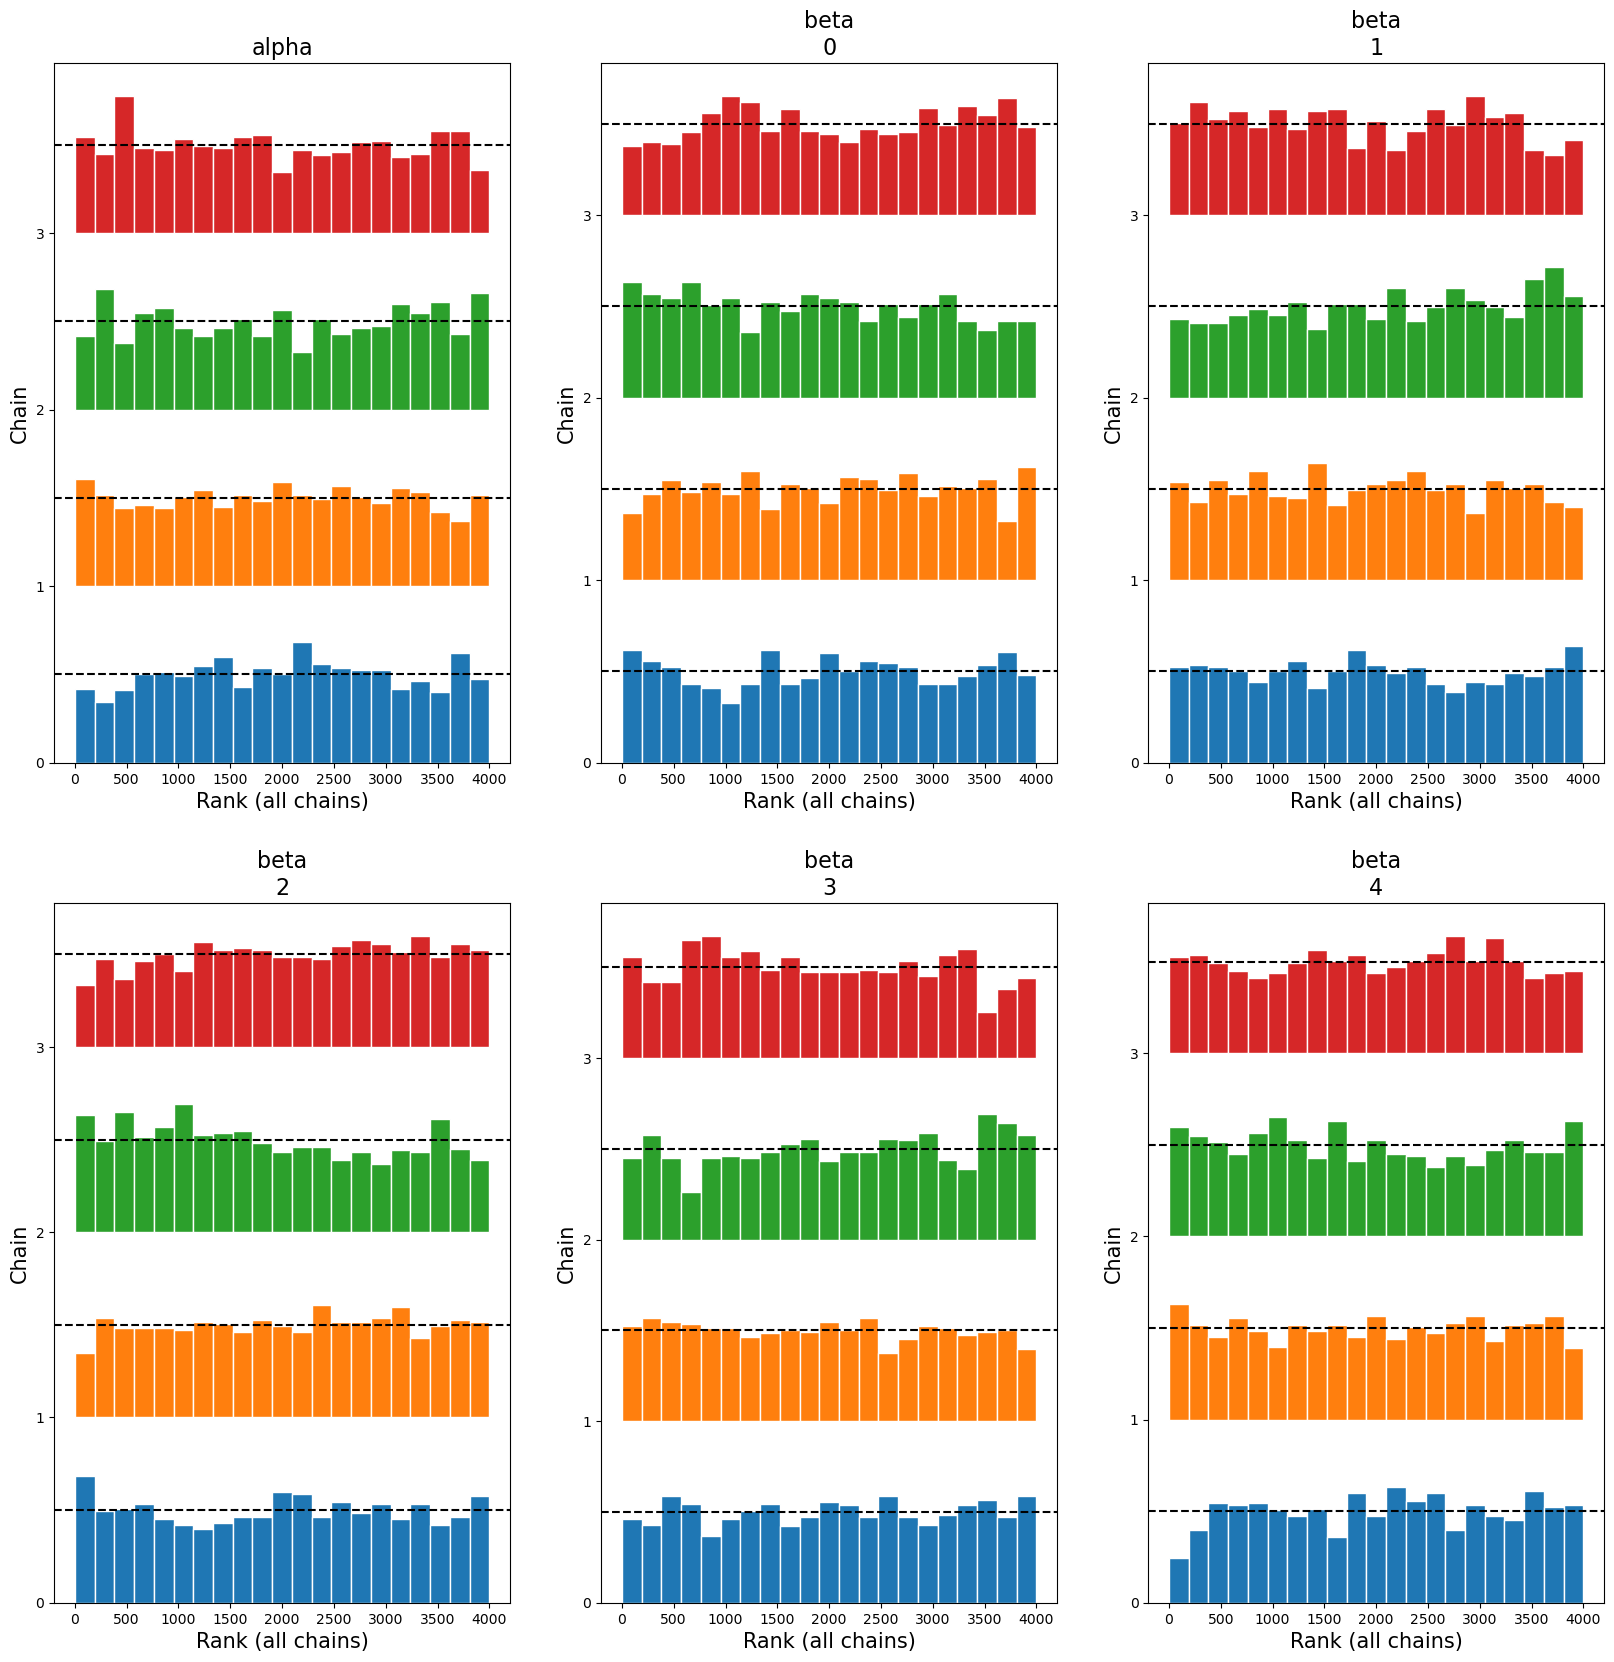

In [37]:
az.plot_rank(trace, var_names=["alpha","beta"], figsize=(20,20));
plt.savefig('vis/rank_rcs.png')

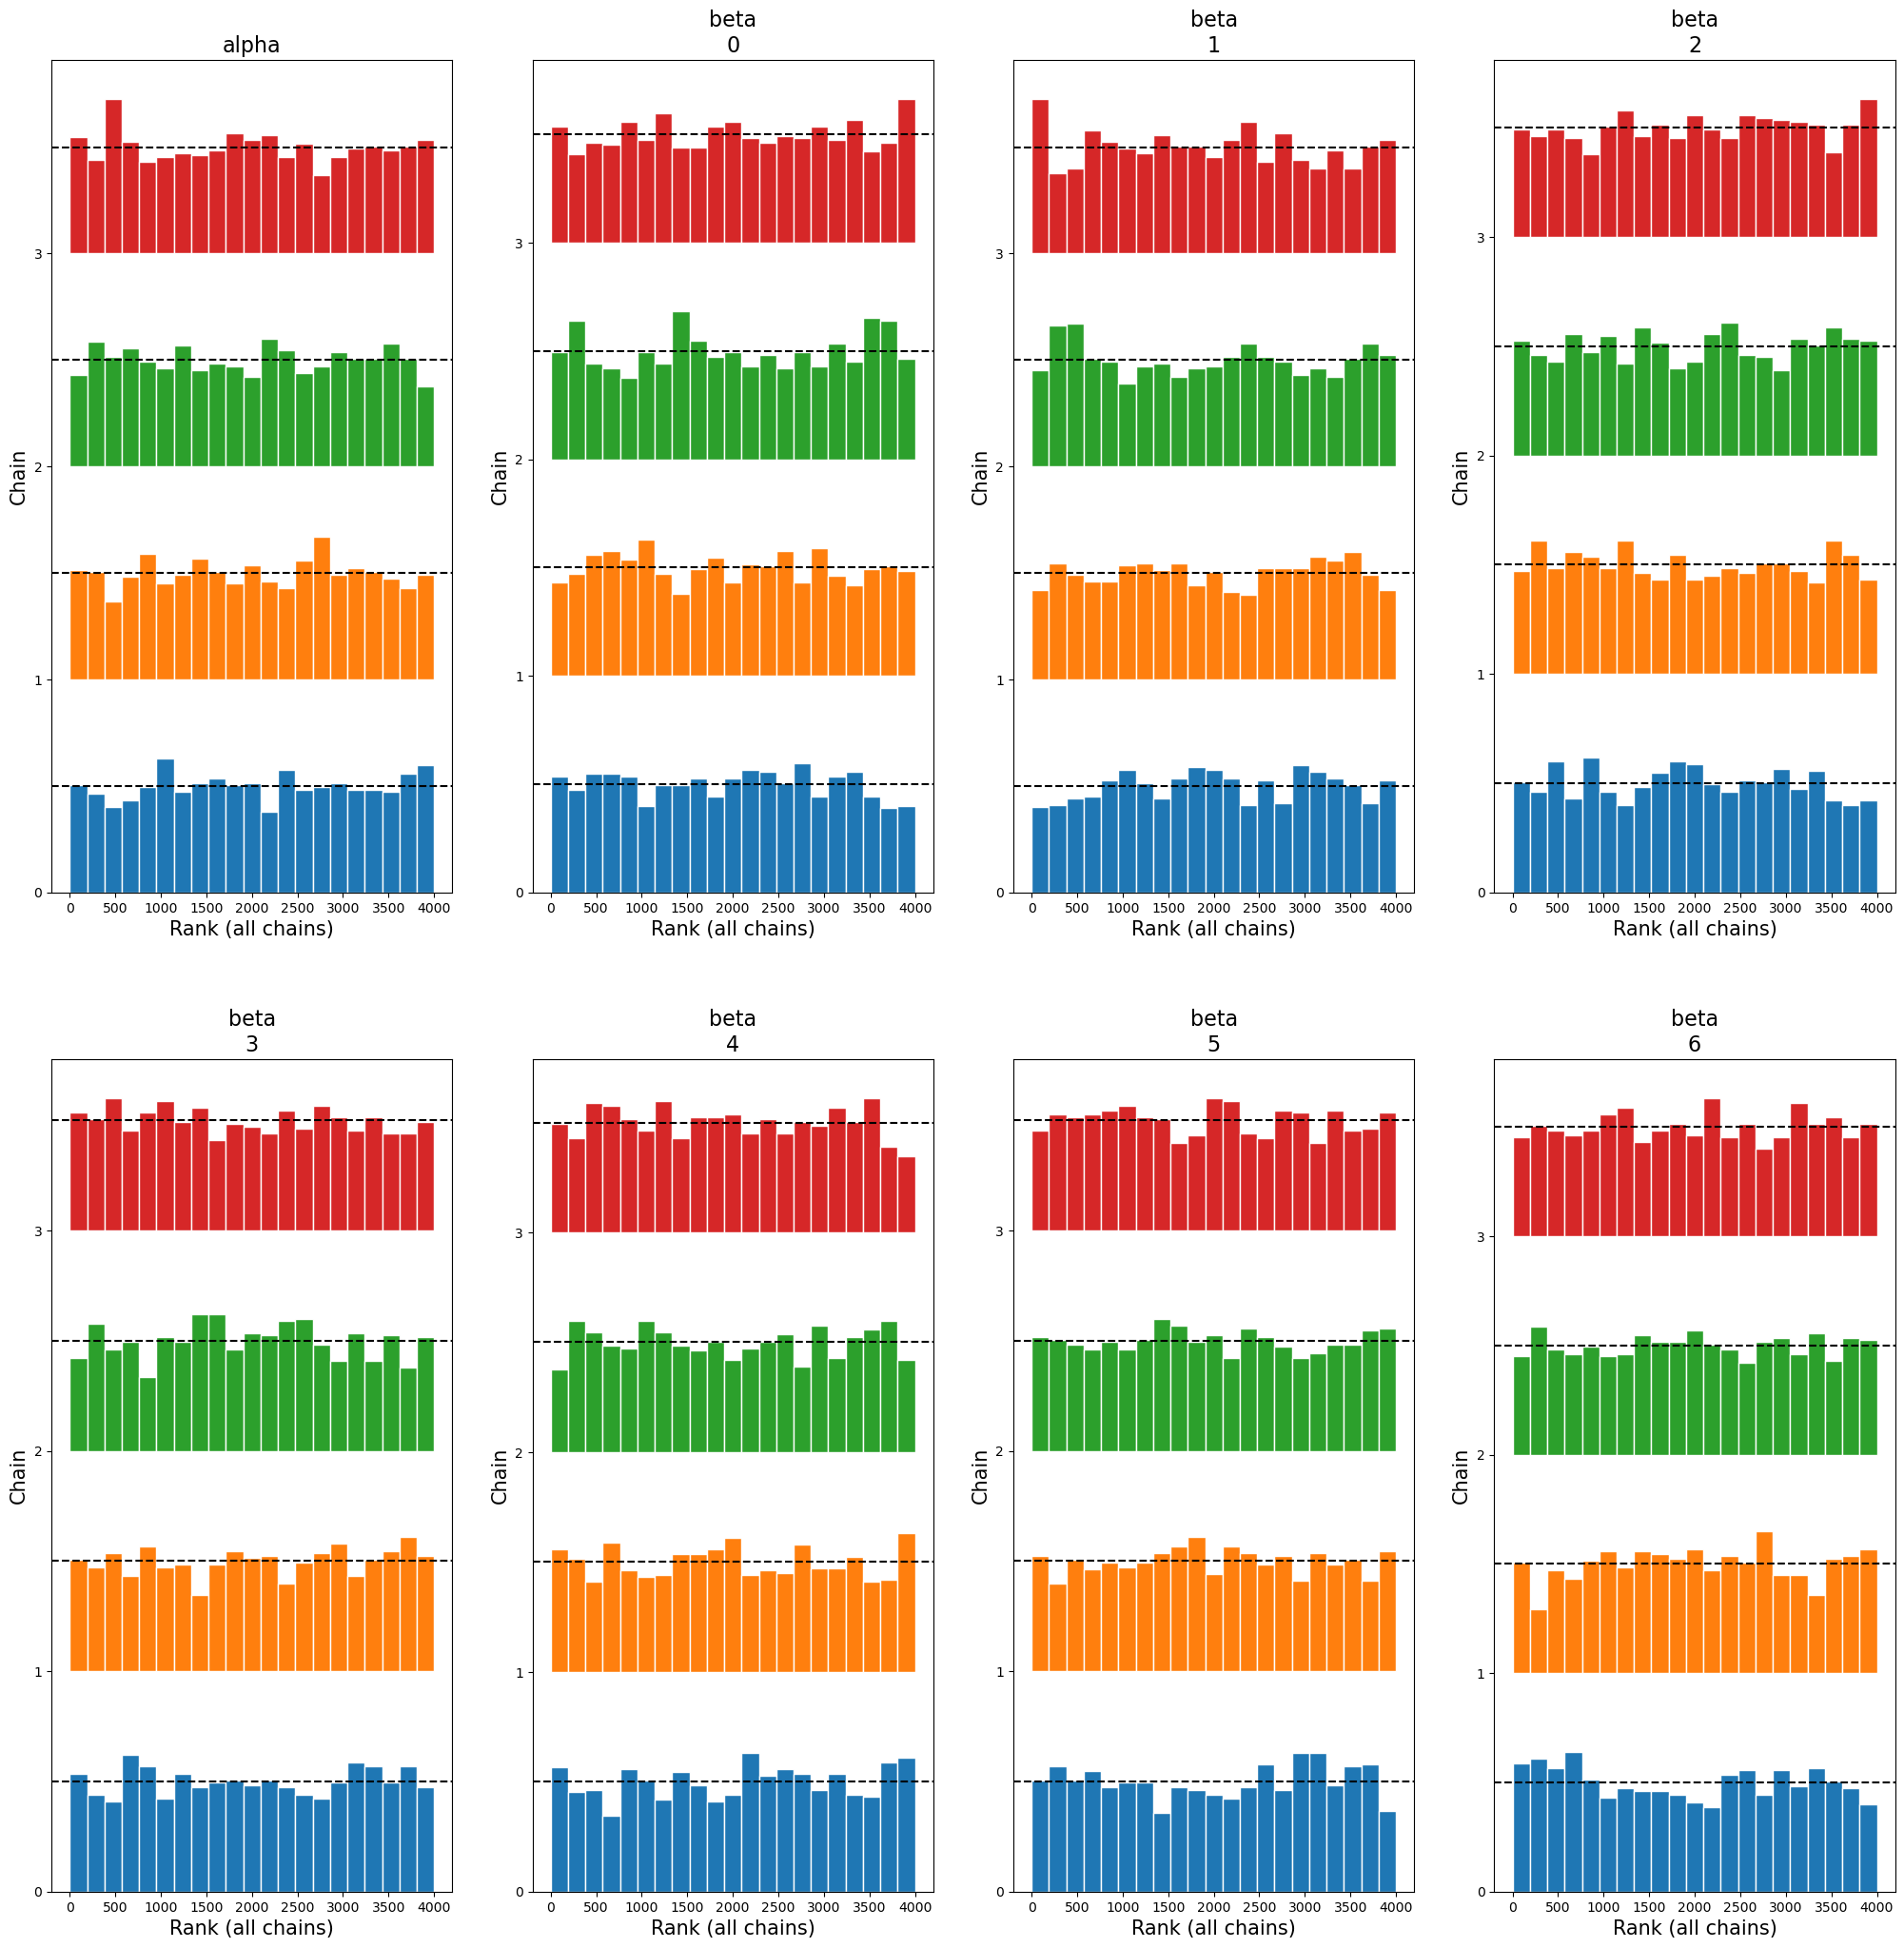

In [38]:
az.plot_rank(trace_cyl, var_names=["alpha", "beta"], figsize=(25,25));
plt.savefig('vis/rank_cyl.png')

Summary for both models showed good effective sample size (ess) for bulk and tail $\geq$ 400 and rhat all at 1.0 which suggest the chains have converged Additionally, the rank plots show no issue or deformity in the chains away from uniformity (Vehtari et al. 2021).

# Model Fit 

/home/harrison/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/lmplot.py:211: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)


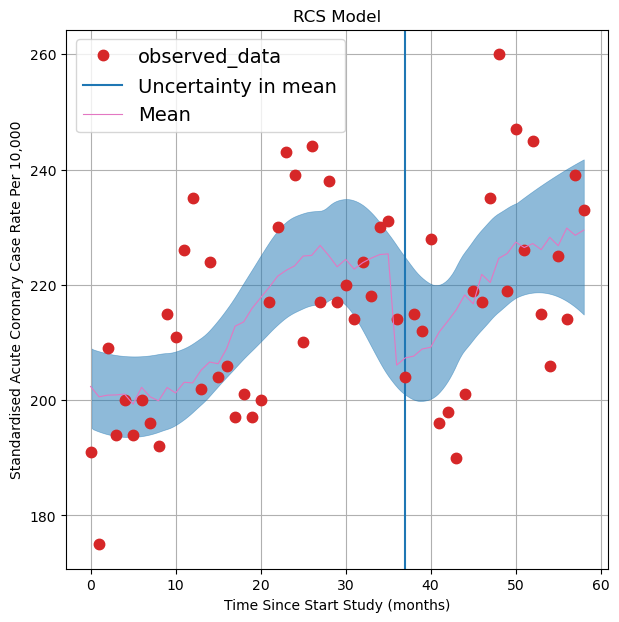

In [39]:
_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(idata=trace, y="y", num_samples=500, axes=ax, kind_model="hdi", y_model="lamda")
plt.ylabel("Standardised Acute Coronary Case Rate Per 10,000")
plt.xlabel("Time Since Start Study (months)")
plt.title("RCS Model");
plt.axvline(intervention_time);
plt.savefig('vis/rcs_fit.png')

/home/harrison/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/lmplot.py:211: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)


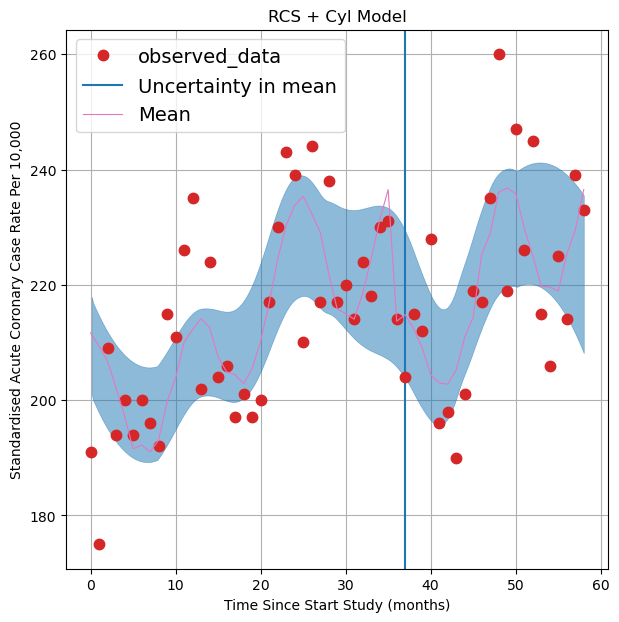

In [40]:
_, ax = plt.subplots(figsize=(7, 7));
az.plot_lm(idata=trace_cyl, y="y", num_samples=500, axes=ax, kind_model="hdi", y_model="lamda");
#plt.axvline(intervention_date);
plt.ylabel('Standardised Acute Coronary Case Rate Per 10,000');
plt.xlabel("Time Since Start Study (months)");
plt.title("RCS + Cyl Model");
plt.axvline(intervention_time);
plt.savefig('vis/cyl_fit.png')

# Posterior predictive checks

In [41]:
# Using model objects  posterior preicitve simulations
with model_rcs:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=1)
with model_cyl:
    pm.sample_posterior_predictive(trace_cyl, extend_inferencedata=True, random_seed=1)

Sampling: [y]


Output()

Sampling: [y]


Output()

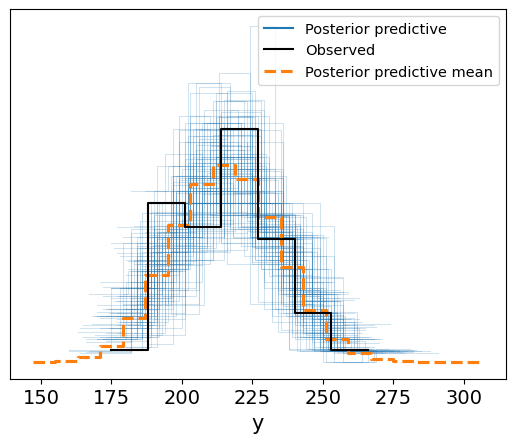

In [42]:
# Plot posterior predictive check plot.
az.plot_ppc(trace, num_pp_samples=100);
plt.savefig('vis/PPC_rcs.png')

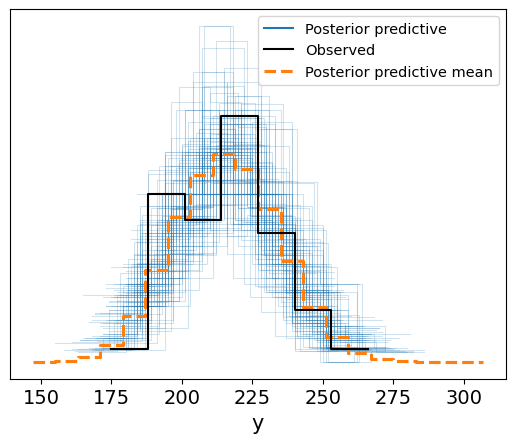

In [43]:
# Plot posterior predictive check.
az.plot_ppc(trace, num_pp_samples=100);
plt.savefig('vis/PPC_cyl.png')

Both models showed a good fit to the data with no major discrepancies between the posterior predictive distributions and the observed data.

## Causal Inference estimates

In [44]:
# Calculate Risk Ratio highest density interval (default 95%) for the impact component of the ITS model.
hdi_rcs_lower, hdi_rcs_higher = RR_hdi_calculator(trace=trace.posterior.beta[:,:,4])
hdi_cyl_lower, hdi_cyl_higher = RR_hdi_calculator(trace=trace_cyl.posterior.beta[:,:,6])

# Risk ratio show decrease for relative risk after intervention of smoking policy in both models
print("Risk Ratio for the RCS model", round(np.exp(trace.posterior.beta[:,:,4].mean().values), 2), "\u00B1", f"CrI[{hdi_rcs_higher},{hdi_rcs_lower}]")
print("Risk Ratio for the RCS with cyclic trend (seasonality) model", round(np.exp(trace_cyl.posterior.beta[:,:,6].mean().values), 2), "\u00B1", f"CrI[{hdi_cyl_higher},{hdi_cyl_lower}]")

Risk Ratio for the RCS model 0.9 ± CrI[1.01,0.8]
Risk Ratio for the RCS with cyclic trend (seasonality) model 0.88 ± CrI[0.99,0.78]


The calculated Risk Ratios (RR) provide insightful outcomes regarding the causal inferences that can be drawn about the impact of smoking regulations on ACE rates in Sicily when applying these specific models to assess causal effects. The interesting outcomes arise when evaluating the causal effect estimates using the statistical standard of assessing values that fall within the 95% credible interval to declare statistical significance (Knowing full well their is no logical basis for this statistical standard, McElreath, 2020).

If the  RCS model is used it leads us to conclude that the introduction of smoking regulations had no impact, as the 95% credible interval crosses an RR of 1. In contrast, when applying the same statistical significance standard under the RCS + Cyl model, we find that the introduction of the regulations resulted in a 12% reduction in risk for ACE rates in Sicily post-intervention.



# Model comparison

In Chapter 2 of Regression Modelling Strategies, the model comparison was conducted using the Akaike information crtierion (AIC). However, in the strictest sense, model comparison metrics should have little impact on which models are used when applying causal inference methods, as the models should be theoretically informed in terms of the estimand and the resulting estimates. However, this example does provide an option to show the superiority of model comparison methods within the Bayesian workflow/framework. Just keep in mind that such methods are designed for selecting the best model in terms of prediction and not causal inference McElreath (2020).

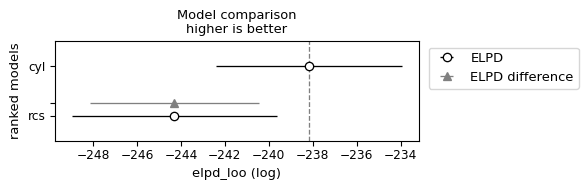

In [45]:
# Use arviz loo comparion methods using log-likelihoods calculated in the run_mod() call.
df_comp_loo = az.compare({"rcs": trace, "cyl": trace_cyl})
az.plot_compare(df_comp_loo, insample_dev=False);
plt.tight_layout();
plt.savefig('vis/loo_comparison_plot.png');

The LOO-CV assessment above shows similar results to the AIC results found by Harrell [see](https://hbiostat.org/rmsc/genreg). However, our Bayesian models provide a much more useful picture in terms of model comparison, as uncertainty estimates naturally arise from the estimated posteriors. This is useful because, although the cyclical model was found to be superior for prediction by Harrell's AIC analysis, that was only in terms of a point estimate. In contrast, the Bayesian LOO-CV analysis above shows, there is a lot of overlap between the models. Therefore, we cannot conclude that the cyclical model is better for prediction than the simpler RCS model.

# References

Abril-Pla, O., Andreani, V., Carroll, C., Dong, L., Fonnesbeck, C. J., Kochurov, M., ... & Zinkov, R. (2023). PyMC: a modern, and comprehensive probabilistic programming framework in Python. PeerJ Computer Science, 9, e1516.

Barone-Adesi, F., Gasparrini, A., Vizzini, L., Merletti, F., & Richiardi, L. (2011). Effects of Italian smoking regulation on rates of hospital admission for acute coronary events: a country-wide study. PloS one, 6(3), e17419.

Bernal, J. L., Cummins, S., & Gasparrini, A. (2017). Interrupted time series regression for the evaluation of public health interventions: a tutorial. International journal of epidemiology, 46(1), 348-355.

Bhaskaran, K., Gasparrini, A., Hajat, S., Smeeth, L., & Armstrong, B. (2013). Time series regression studies in environmental epidemiology. International journal of epidemiology, 42(4), 1187-1195.

Brodersen, K. H., Hauser, A., & Hauser, M. A. (2017). Package CausalImpact. Google LLC: Mountain View, CA, USA.

Lundberg, I., Johnson, R., & Stewart, B. M. (2021). What is your estimand? Defining the target quantity connects statistical evidence to theory. American Sociological Review, 86(3), 532-565.

McElreath R. Statistical Rethinking. 2nd Edition. London (UK): Routledge; 2020.

Devlin, T. F., & Weeks, B. J. (1986). Spline functions for logistic regression modeling. Proceedings of the Eleventh Annual SAS Users Group International Conference, 646–651.

Vehtari, A., Gelman, A., Simpson, D., Carpenter, B., & Bürkner, P. C. (2021). Rank-normalization, folding, and localization: An improved R ̂ for assessing convergence of MCMC (with discussion). Bayesian analysis, 16(2), 667-718.

# Web resources
https://hbiostat.org/rmsc/

https://github.com/harrelfe/Hmisc